# Аналитика в Яндекс.Афише

Имеются данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

**Задача:** найти способы оптимизировать маркетинговые затраты.

**Описание данных**

Таблица `visits` (лог сервера с информацией о посещениях сайта):
- `Uid` — уникальный идентификатор пользователя
- `Device` — категория устройства пользователя
- `Start Ts` — дата и время начала сессии
- `End Ts` — дата и время окончания сессии
- `Source Id` — идентификатор рекламного источника, из которого пришел пользователь

Таблица orders (информация о заказах):
- `Uid` — уникальный id пользователя, который сделал заказ
- `Buy Ts` — дата и время заказа
- `Revenue` — выручка Яндекс.Афиши с этого заказа

Таблица costs (информация о затратах на маркетинг):
- `source_id` — идентификатор рекламного источника
- `dt` — дата
- `costs` — затраты на этот рекламный источник в этот день



**Структура работы**

1. [Загрузка данных и первый взгляд](#data_import)
    - [Вывод](#sum_up_1) 
2. [Метрики активности](#activity_metrics)
    - [Вывод](#sum_up_2)
3. [Метрики продаж](#sales_metrics)
    - [Вывод](#sum_up_3)
4. [Маркетинговые метрики](#marketing_metrics)
    - [Вывод](#sum_up_4)
5. [Общий вывод](#sum_up)

<a id="data_import"></a>
## Загрузка данных и первый взгляд

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

In [2]:
visits = pd.read_csv('visits_log.csv')
orders = pd.read_csv('orders_log.csv')
costs = pd.read_csv('costs.csv')

In [3]:
visits.head(10)

Device               End Ts  Source Id             Start Ts  \
0    touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
1  desktop  2018-02-19 17:21:00          2  2018-02-19 16:53:00   
2    touch  2017-07-01 01:54:00          5  2017-07-01 01:54:00   
3  desktop  2018-05-20 11:23:00          9  2018-05-20 10:59:00   
4  desktop  2017-12-27 14:06:00          3  2017-12-27 14:06:00   
5  desktop  2017-09-03 21:36:00          5  2017-09-03 21:35:00   
6  desktop  2018-01-30 12:09:00          1  2018-01-30 11:13:00   
7    touch  2017-11-05 15:15:00          3  2017-11-05 15:14:00   
8  desktop  2017-07-19 10:44:00          3  2017-07-19 10:41:00   
9  desktop  2017-11-08 13:43:00          5  2017-11-08 13:42:00   

                    Uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527  
3  16174680259334210214  
4   9969694820036681168  
5  16007536194108375387  
6   6661610529277171451  
7  11423865690854540312  
8   2987360259350925644  
9   1289240080042562063

In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [5]:
visits.columns = [i.lower().replace(' ', '_') for i in visits.columns]

In [6]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format='%Y-%m-%d %H:%M:%S')
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format='%Y-%m-%d %H:%M:%S')

In [7]:
visits[visits['start_ts'] > visits['end_ts']]

device              end_ts  source_id            start_ts  \
4181    desktop 2018-03-25 03:18:00          3 2018-03-25 03:50:00   
177972  desktop 2018-03-25 03:09:00          9 2018-03-25 03:55:00   

                         uid  
4181    13092152539246794986  
177972   4621202742905035453

В двух случаях время окончания визита раньше времени его начала. Эти строки удалим из таблицы.

In [8]:
visits = visits[visits['start_ts'] <= visits['end_ts']]

In [9]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359398 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359398 non-null  object        
 1   end_ts     359398 non-null  datetime64[ns]
 2   source_id  359398 non-null  int64         
 3   start_ts   359398 non-null  datetime64[ns]
 4   uid        359398 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 16.5+ MB


In [10]:
orders.head(10)

Buy Ts  Revenue                   Uid
0  2017-06-01 00:10:00    17.00  10329302124590727494
1  2017-06-01 00:25:00     0.55  11627257723692907447
2  2017-06-01 00:27:00     0.37  17903680561304213844
3  2017-06-01 00:29:00     0.55  16109239769442553005
4  2017-06-01 07:58:00     0.37  14200605875248379450
5  2017-06-01 08:43:00     0.18  10402394430196413321
6  2017-06-01 08:54:00     1.83  12464626743129688638
7  2017-06-01 09:22:00     1.22   3644482766749211722
8  2017-06-01 09:22:00     3.30  17542070709969841479
9  2017-06-01 09:23:00     0.37   1074355127080856382

In [11]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [12]:
orders.columns = [i.lower().replace(' ', '_') for i in orders.columns]

In [13]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format='%Y-%m-%d %H:%M:%S')

In [14]:
len(orders[orders['revenue'] <= 0])

51

Есть 51 заказ, в которых выручка неположительная. Их тоже удалим.

In [15]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [16]:
costs.head(10)

source_id          dt  costs
0          1  2017-06-01  75.20
1          1  2017-06-02  62.25
2          1  2017-06-03  36.53
3          1  2017-06-04  55.00
4          1  2017-06-05  57.08
5          1  2017-06-06  40.39
6          1  2017-06-07  40.59
7          1  2017-06-08  56.63
8          1  2017-06-09  40.16
9          1  2017-06-10  43.24

In [17]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [18]:
costs['dt'] = pd.to_datetime(costs['dt'])

In [19]:
costs[costs['costs'] <= 0]

Empty DataFrame
Columns: [source_id, dt, costs]
Index: []

<a id="sum_up_1"></a>
**Вывод**

Данные загружены. В имеющихся выгрузках отсутствуют пропуски. Тип переменных с датами заменен со строковых на корректный формат. Убраны строки, где время окончания сессии раньше времени ее начала, а также заказы, в которых выручка меньше или равна нулю.

<a id="activity_metrics"></a>
## Метрики активности

В первую очередь изучим активность пользователей: сколько людей пользуются сервисом в течение дня, недели, месяца, какова средняя продолжительность сессии и как часто пользователи возвращаются на платформу.

In [20]:
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')
visits['session_date'] = visits['start_ts'].astype('datetime64[D]')
visits['session_week']  = visits['session_date'] - pd.to_timedelta(visits['session_date'].dt.dayofweek, unit='d')

In [21]:
dau = visits.groupby('session_date').agg({'uid': 'nunique'}).mean().round().astype('int')

In [22]:
wau = visits.groupby('session_week').agg({'uid': 'nunique'}).mean().round().astype('int')

In [23]:
mau = visits.groupby('session_month').agg({'uid': 'nunique'}).mean().round().astype('int')

In [24]:
print('Посещаемость. Уникальных пользователей\n\
    в день: {}\n\
    в неделю: {}\n\
    в месяц: {}'.format(dau[0], wau[0], mau[0]))

Посещаемость. Уникальных пользователей
    в день: 908
    в неделю: 5716
    в месяц: 23228


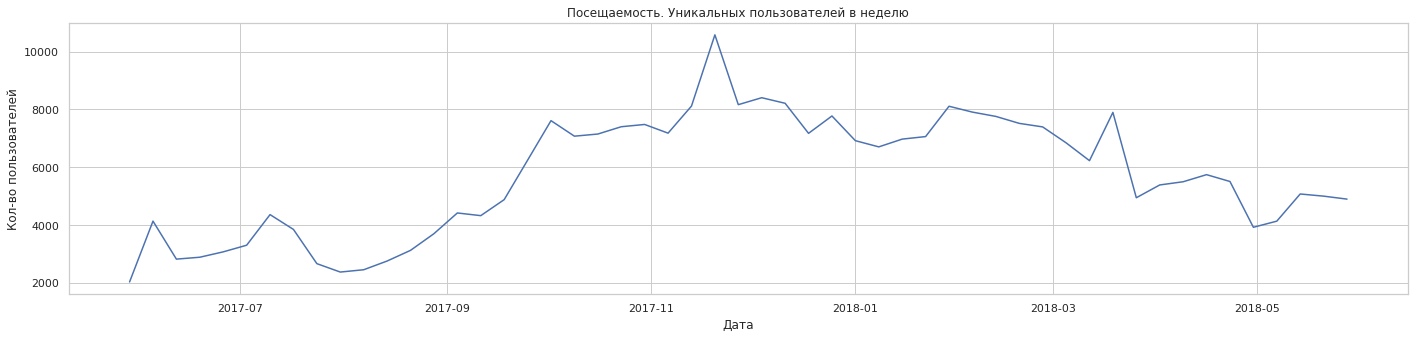

In [25]:
plt.figure(figsize=(24,5))
ax = sns.lineplot(data=visits.groupby('session_week').agg({'uid': 'nunique'}).reset_index(),
                  x = 'session_week',
                  y = 'uid',
                  dashes=False,
                 palette = sns.color_palette("mako_r", 7))
ax.set_title('Посещаемость. Уникальных пользователей в неделю')
ax.set_ylabel('Кол-во пользователей')
ax.set_xlabel('Дата');

В летние месяцы 2017 года посещаемость была менее 15 тыс. уникальных пользователей. С августа по декабрь 2017 месячная посещаемость выросла почти в 3 раза: с 11 тыс. до 31 тыс. Затем, с начала 2018 года до мая, постепенно опустилась до 20 тыс. Резкий рост может объясняться как сезонностью (например, люди чаще посещают различные мероприятия в период новогодних праздников), так и изменениями в стратегии компании.

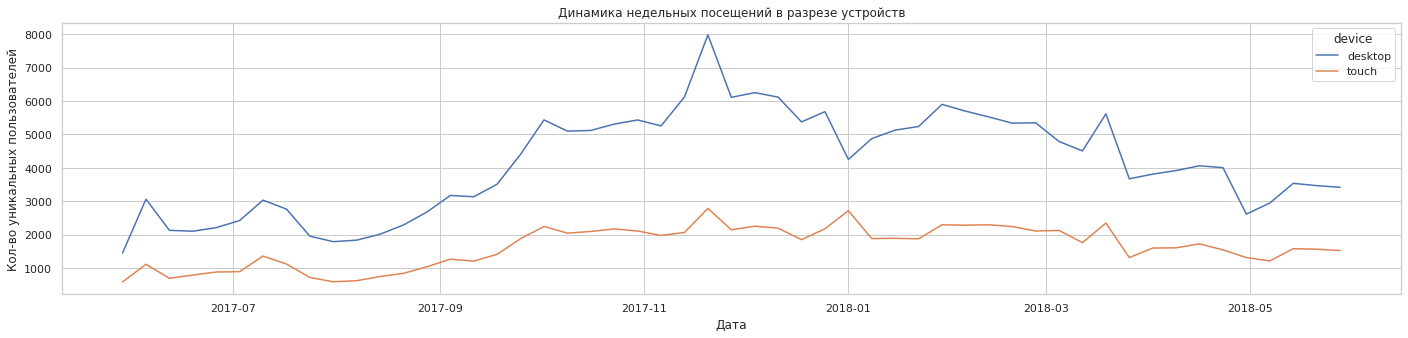

In [26]:
plt.figure(figsize=(24,5))
ax = sns.lineplot(data = visits.groupby(['session_week', 'device']).agg({'uid': 'nunique'}).reset_index(),
                  x = 'session_week',
                  y = 'uid',
                  hue = 'device',
                  dashes=False)
ax.set_title('Динамика недельных посещений в разрезе устройств')
ax.set_ylabel('Кол-во уникальных пользователей')
ax.set_xlabel('Дата');

Посещений с мобильных устройств значительно меньше. Вероятно, есть какие-то проблемы с удобством использования мобильного приложения.

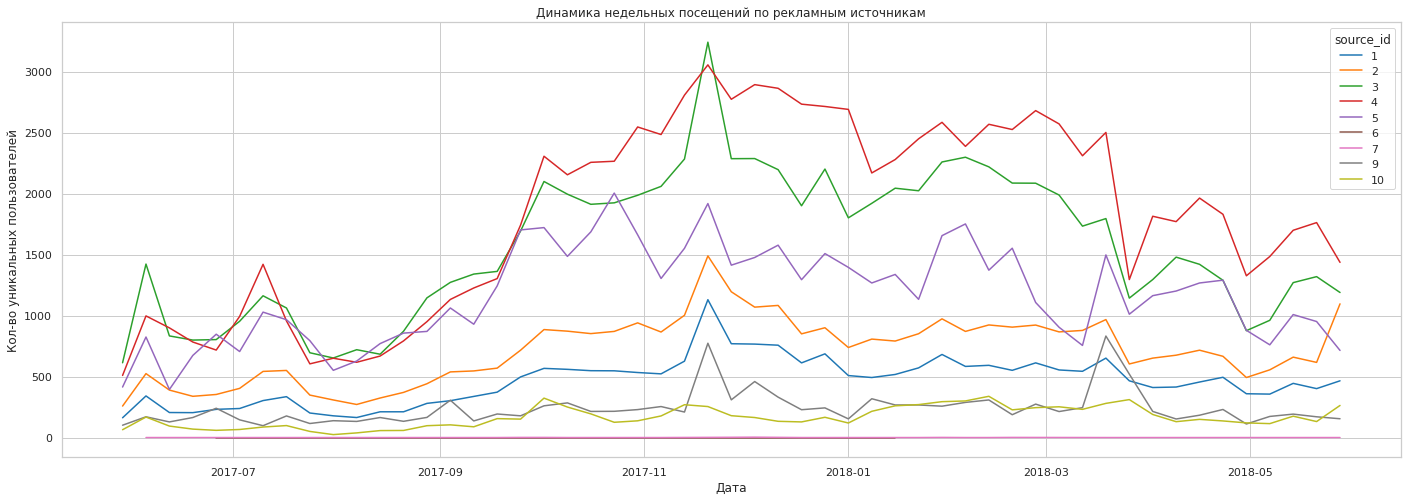

In [27]:
plt.figure(figsize=(24,8))
ax = sns.lineplot(data = visits.groupby(['session_week', 'source_id']).agg({'uid': 'nunique'}).reset_index(),
                  x = 'session_week',
                  y = 'uid',
                  hue = 'source_id',
                  dashes=False,
                  palette = sns.color_palette("tab10", 9))
ax.set_title('Динамика недельных посещений по рекламным источникам')
ax.set_ylabel('Кол-во уникальных пользователей')
ax.set_xlabel('Дата');

В период спада посещаемости через источники 3, 4, 5 заходило примерно одинаковое количество пользователей. В период роста разброс между этими источниками резко увеличился. Самым эффективным оказался источник 4, наименее успешным - 5, источник 3 оказался самым удачным для привлечения на новогодние праздники.

In [28]:
daily_sessions = visits.groupby('session_date').agg({'uid': 'count'}).mean()

In [29]:
print('Среднее количество сессий в день: {}'.format(int(round(daily_sessions[0]))))

Среднее количество сессий в день: 987


В среднем сессий в день больше, чем количество уникальных пользователей. Это логично: наш сервис предлагает возможность купить билеты на различные мероприятия, а люди часто посещают их вместе. Поэтому нормально, когда человек сначала выбирает несколько вариантов, затем обсуждает их со своими спутниками, после чего заходит снова, чтобы сделать окончательный выбор.

In [30]:
monthly_sessions_device = visits.groupby(['session_month', 'device']).agg({'uid':'count'}).reset_index()
monthly_sessions_src = visits.groupby(['session_month', 'source_id']).agg({'uid':'count'}).reset_index()

In [31]:
monthly_sessions_device['unique'] = visits.groupby(['session_month', 'device']).agg({'uid':'count'}).reset_index()['uid'] /\
     visits.groupby(['session_month', 'device']).agg({'uid':'nunique'}).reset_index()['uid']

In [32]:
monthly_sessions_src['unique'] = visits.groupby(['session_month', 'source_id']).agg({'uid':'count'}).reset_index()['uid'] /\
     visits.groupby(['session_month', 'source_id']).agg({'uid':'nunique'}).reset_index()['uid']

In [33]:
plt.figure(figsize=(24,8))
ax = sns.lineplot(data = monthly_sessions_device,
                  x = 'session_month',
                  y = 'unique',
                  hue = 'device',
                  dashes=False)
ax.set_title('Среднее количество сессий на пользователя в месяц по устройствам')
ax.set_ylabel('Кол-во сессий')
ax.set_xlabel('Дата');

С мобильных устроиств пользователи реже заходят повторно в течение месяца, но незначительно.

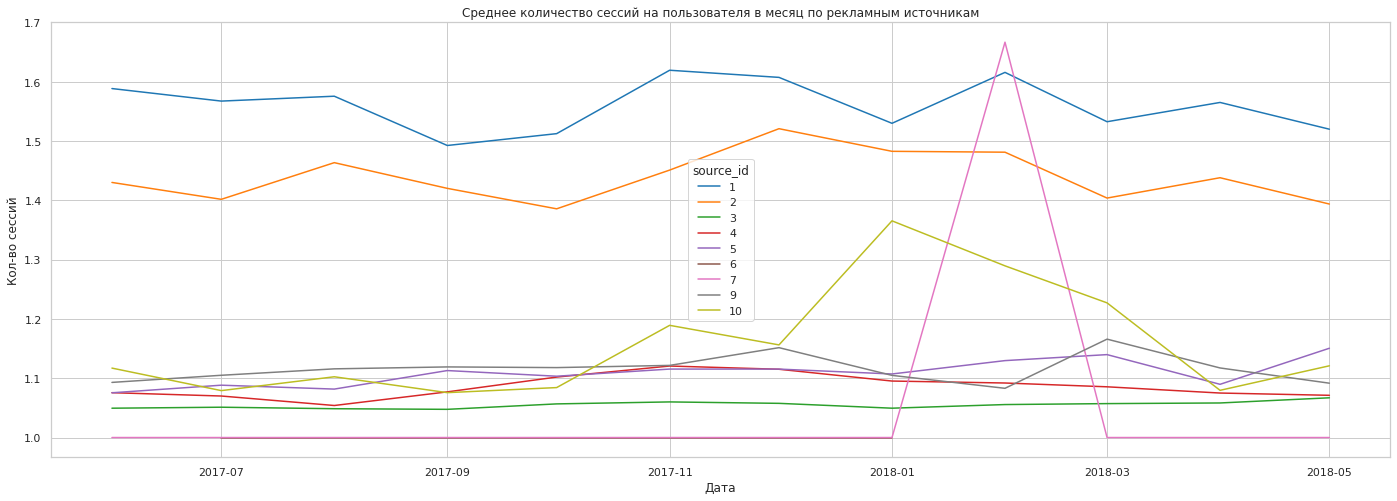

In [34]:
plt.figure(figsize=(24,8))
ax = sns.lineplot(data = monthly_sessions_src,
                  x = 'session_month',
                  y = 'unique',
                  hue = 'source_id',
                  dashes=False,
                  palette = sns.color_palette("tab10", 9))
ax.set_title('Среднее количество сессий на пользователя в месяц по рекламным источникам')
ax.set_ylabel('Кол-во сессий')
ax.set_xlabel('Дата');

Через источники 1 и 2 пользователи чаще всего заходили повторно. В феврале 2018 года чаще всего возвращались пользователи, привлеченные через источник 7.

In [35]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

In [36]:
len(visits[visits['session_duration_sec'] == 0])

35794

Почти 10% сессий длительностью 0 секунд. Это тоже может сигнализировать о технической ошибке в сервисе или сборе данных.

In [37]:
session_avg_duration = visits['session_duration_sec'].mean().round().astype('int')

In [38]:
print('Средняя продолжительность сессии: {} секунды'.format(session_avg_duration))

Средняя продолжительность сессии: 643 секунды


In [39]:
visits['session_duration_sec'].hist(bins=100, range=(0,6000));

In [40]:
print('Наиболее частая продолжительность сессии: {} секунд'.format(visits['session_duration_sec'].mode()[0]))

Наиболее частая продолжительность сессии: 60 секунд


Несмотря на то, что в среднем сессия длится около 10,5 минут, чаще всего встречается значение ровно в 1 минуту. Это может быть связано с какими-то техническими ошибками ресурса. Сравним продолжительность сессии в зависимости от устройства входа.

In [41]:
visits['device'].unique()

array(['touch', 'desktop'], dtype=object)

In [42]:
visits[visits['device'] == 'desktop']['session_duration_sec'].mode()[0],\
    visits[visits['device'] == 'touch']['session_duration_sec'].mode()[0]

(60, 60)

In [43]:
visits[visits['device'] == 'desktop']['session_duration_sec'].mean().round().astype('int'),\
    visits[visits['device'] == 'touch']['session_duration_sec'].mean().round().astype('int')

(703, 480)

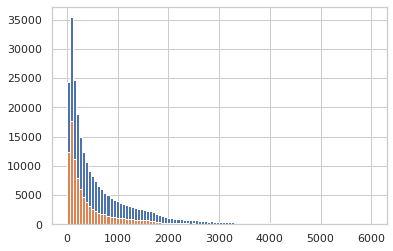

In [44]:
visits[visits['device'] == 'desktop']['session_duration_sec'].hist(bins=100, range=(0,6000)),\
    visits[visits['device'] == 'touch']['session_duration_sec'].hist(bins=100, range=(0,6000));

В разрезе девайсов ситуация с самой частой продолжительностью не изменилась, значит проблема не в приложении. На мобильных устройствах в среднем сессия короче. Это кажется нормальным.

In [45]:
visits = (visits.join(visits.groupby('uid').agg({'start_ts': 'min'})
                      .astype('datetime64[M]')
                      .rename(columns={'start_ts': 'first_visiting_month'}), on='uid'))
cohorts = visits.groupby(['first_visiting_month', 'session_month']).agg({'uid': 'nunique'}).reset_index()
cohorts['cohort_lifetime'] = cohorts['session_month'] - cohorts['first_visiting_month']
cohorts['cohort_lifetime'] = cohorts['cohort_lifetime'] / np.timedelta64(1, 'M')
cohorts['cohort_lifetime'] = cohorts['cohort_lifetime'].round().astype('int')

In [46]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visiting_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_size'})
cohorts = cohorts.merge(initial_users_count,on='first_visiting_month')

In [47]:
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_size']

In [48]:
retention_pivot = cohorts.pivot_table(index='first_visiting_month',
                                      columns='cohort_lifetime',
                                      values='retention',
                                      aggfunc='sum')

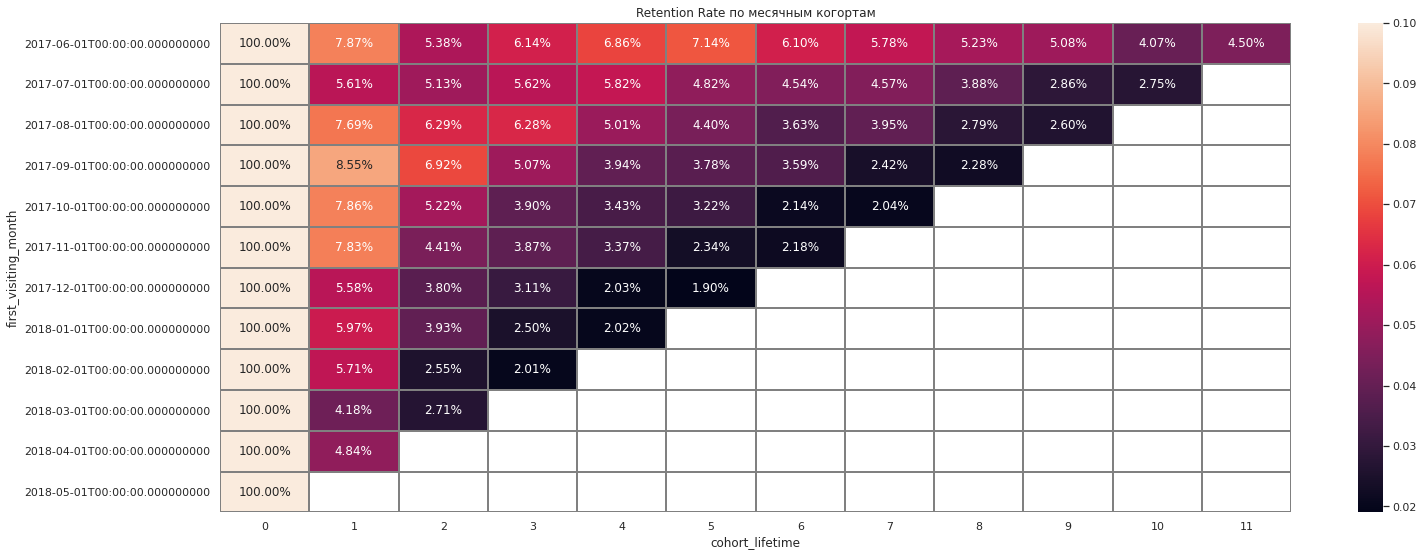

In [49]:
plt.figure(figsize=(24, 9))
plt.title('Retention Rate по месячным когортам')
sns.heatmap(retention_pivot, annot=True, fmt='.2%', linewidths=1, linecolor='gray', vmax=0.1);

Сервису удается удержать в лучшем случае 8,5% пользователей после первого месяца использования. Пользователи первой когорты стабильно возвращаются по сравнению с остальными. В более поздних когортах резче снижается процент возвращающихся пользователей. Существует проблема удержания пользователей: чем новее когорта, тем меньше желания у пользователей повторно воспользоваться нашим ресурсом.

<a id="sum_up_2"></a>
**Вывод**

- Пользователи, привлеченные рекламными источниками 3, 4, 5 чаще других заходят на сервис. Источник 3 привлек больше других в новогодние праздники, источник 4 привлекает в среднем больше всего посещений.
- Повторно чаще заходят пользователи, привлеченные источниками 1 и 2.
- Самая частая продолжительность сессии как на мобильных устройствах, так и на компьютерах составила *60 секунд*. Это может быть связано с технической ошибкой.
- На мобильных устройствах в среднем сессии короче на *3,5 минуты*. При посещении с компьютера у пользователя, вероятно больше времени на выбор, однако стоит обратить внимание на удобство интерфейса сайта по сравнению с мобильным приложением.
- С течением времени отток пользователей увеличивается. В более новых когортах процент удержания пользователей снижается более стремительно. В среднем удается удержать не более **5%** от первоначального размера месячной когорты.
- Количество посещений растет осенью и зимой, а летом достигает минимума.

<a id="sales_metrics"></a>
## Метрики продаж

Следующим этапом рассмотрим, насколько активно пользователи покупают билеты на Яндекс.Афише: количество покупок в месяц, средний чек, сколько денег приносит клиент за весь период пользования ресурсом.

In [50]:
first_order_date_by_uid = orders.groupby('uid')['buy_ts'].min()
first_order_date_by_uid.name = 'first_order_date'
orders = orders.join(first_order_date_by_uid, on='uid')
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')

In [51]:
orders.head()

buy_ts  revenue                   uid    first_order_date  \
0 2017-06-01 00:10:00    17.00  10329302124590727494 2017-06-01 00:10:00   
1 2017-06-01 00:25:00     0.55  11627257723692907447 2017-06-01 00:25:00   
2 2017-06-01 00:27:00     0.37  17903680561304213844 2017-06-01 00:27:00   
3 2017-06-01 00:29:00     0.55  16109239769442553005 2017-06-01 00:29:00   
4 2017-06-01 07:58:00     0.37  14200605875248379450 2017-06-01 07:58:00   

  first_order_month order_month  
0        2017-06-01  2017-06-01  
1        2017-06-01  2017-06-01  
2        2017-06-01  2017-06-01  
3        2017-06-01  2017-06-01  
4        2017-06-01  2017-06-01

In [52]:
orders = orders[orders['order_month'] < '2018-06-01']
visits = visits[visits['session_month'] < '2018-06-01']

In [53]:
first_order_gap = orders.merge(visits, on='uid')

In [54]:
first_order_gap['first_order_gap'] = first_order_gap['first_order_month'] -\
                                    first_order_gap['first_visiting_month']
first_order_gap['first_order_gap'] = (first_order_gap['first_order_gap'] /\
                                      np.timedelta64(1, 'M')).round().astype('int')

In [55]:
first_order_gap.groupby('first_order_gap').agg({'uid': 'nunique'}).reset_index()

first_order_gap    uid
0                 0  30087
1                 1   2299
2                 2   1081
3                 3    830
4                 4    668
5                 5    513
6                 6    369
7                 7    259
8                 8    181
9                 9    122
10               10     59
11               11     54

In [56]:
len(first_order_gap['uid'].unique())

36522

In [57]:
len(visits['uid'].unique()), len(orders['uid'].unique())

(228169, 36522)

In [58]:
plt.figure(figsize=(16,5))
ax = sns.lineplot(data=first_order_gap.groupby('first_order_gap').agg({'uid': 'nunique'}).reset_index(),
                  x = 'first_order_gap',
                  y = 'uid',
                  dashes=False)
ax.set_title('Месяц первой покупки после регистрации')
ax.set_ylabel('Кол-во пользователей')
ax.set_xlabel('Кол-во месяцев после регистрации до первой покупки');

В базе 36,5 тыс. пользователей, которые совершали заказ в течение изучаемого периода. Из них 30 тыс. совершают покупку в первый же месяц, еще 3 тыс. оформляют первый заказ в течение второго-третьего месяцев пользования.

In [59]:
orders_total_monthly_pivot = orders.pivot_table(index='first_order_month',
    columns='order_month',
    values='uid',
    aggfunc='count')

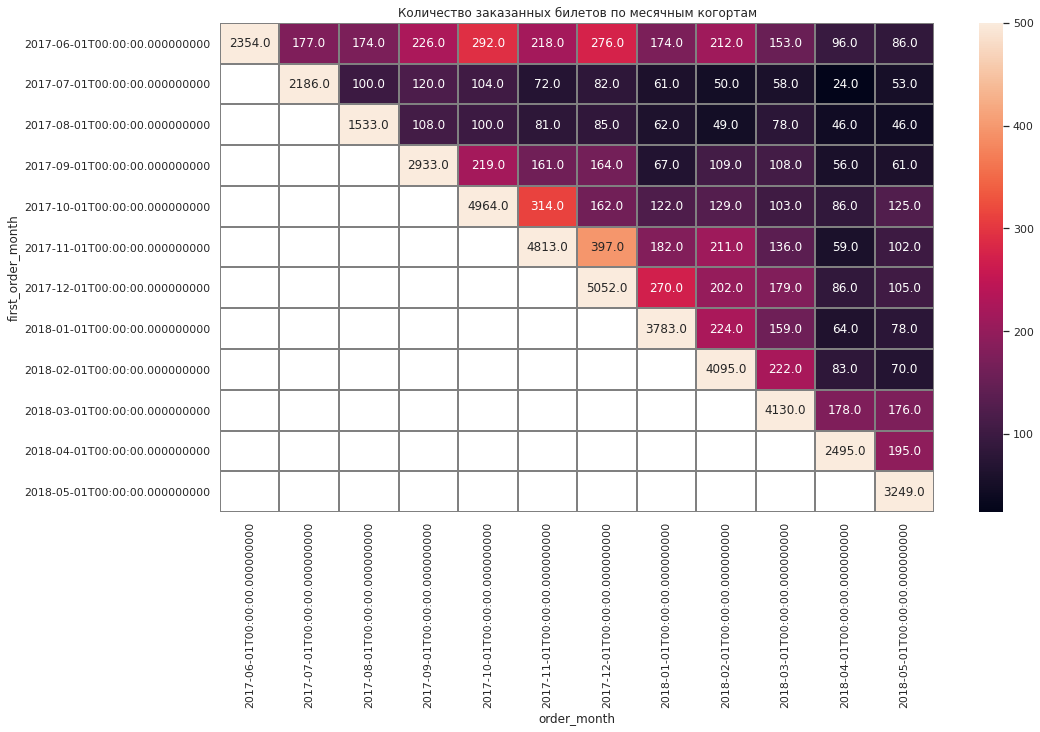

In [60]:
plt.figure(figsize=(16, 9))
plt.title('Количество заказанных билетов по месячным когортам')
sns.heatmap(orders_total_monthly_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray', vmax=500);

В течение всего рассматриваемого периода клиенты покупали значительно больше билетов в первый месяц, чем в последующие. Как правило, количество купленных билетов с каждым месяцем падает. Интересно, что в половине когорт в мае 2018 года количество билетов либо выросло либо осталось равным предыдущему месяцу. Возможно, в мае у Яндекс.Афиши состоялась акция,которая позволила привлечь клиентов к повторной покупке. Однако, несмотря на это продажи в первый месяц все равно превышают совокупные продажи за все последующие месяцы.

In [61]:
orders_grouped_by_cohorts = (orders
                             .groupby(['first_order_month','order_month'])
                             .agg({'revenue':'sum','uid':'nunique'})
                             .reset_index())
orders_grouped_by_cohorts['revenue_per_user'] = orders_grouped_by_cohorts['revenue'] /\
                                                orders_grouped_by_cohorts['uid']
mean_orders_revenue_pivot = (orders_grouped_by_cohorts
                             .pivot_table(index='first_order_month',
                                          columns='order_month',
                                          values='revenue_per_user',
                                          aggfunc='mean'))

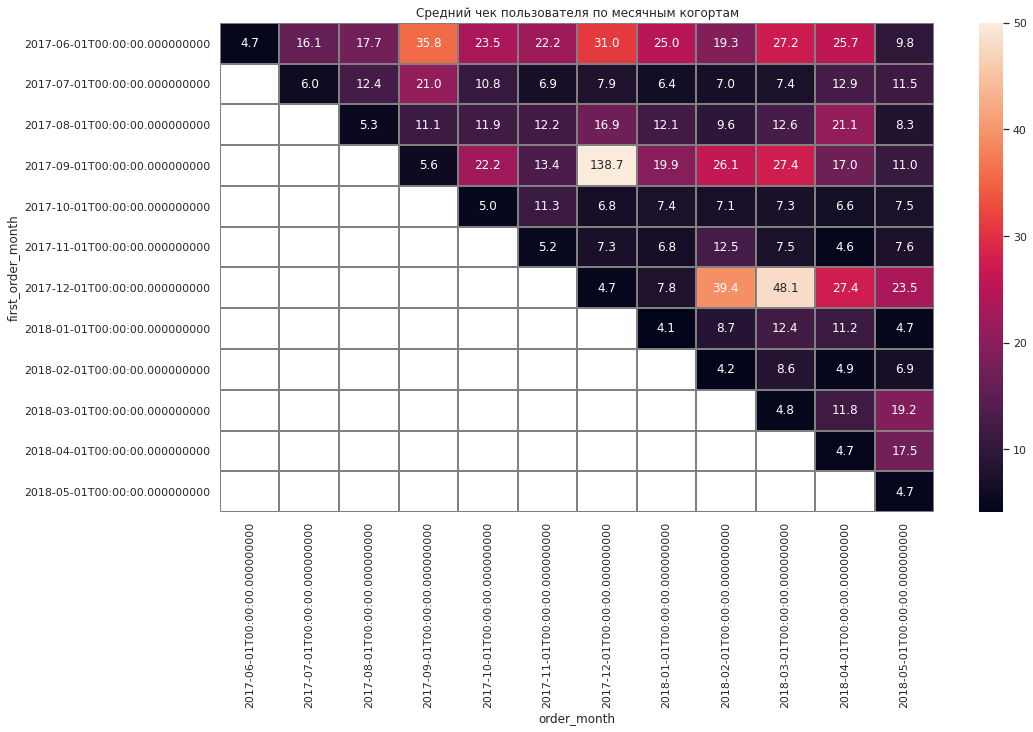

In [62]:
plt.figure(figsize=(16, 9))
plt.title('Средний чек пользователя по месячным когортам')
sns.heatmap(mean_orders_revenue_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray', vmax=50);

В декабре 2017 есть выброс по среднему чеку. Поскольку это месяц новогодних корпоративов, вероятнее всего, что в один чек попадали все билеты на компанию. Непонятно, правда, почему есть выброс только по одной месячной когорте.

Средний чек в первом месяце всегда ниже, чем в последующих. Это хорошо, поскольку пользователи, которые остаются, приносят больше денег, однако мы помним, что в первый месяц общее число покупок всегда на порядок выше.

In [63]:
costs['month'] = costs['dt'].astype('datetime64[M]')

In [64]:
orders.head()

buy_ts  revenue                   uid    first_order_date  \
0 2017-06-01 00:10:00    17.00  10329302124590727494 2017-06-01 00:10:00   
1 2017-06-01 00:25:00     0.55  11627257723692907447 2017-06-01 00:25:00   
2 2017-06-01 00:27:00     0.37  17903680561304213844 2017-06-01 00:27:00   
3 2017-06-01 00:29:00     0.55  16109239769442553005 2017-06-01 00:29:00   
4 2017-06-01 07:58:00     0.37  14200605875248379450 2017-06-01 07:58:00   

  first_order_month order_month  
0        2017-06-01  2017-06-01  
1        2017-06-01  2017-06-01  
2        2017-06-01  2017-06-01  
3        2017-06-01  2017-06-01  
4        2017-06-01  2017-06-01

In [65]:
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_revenue = orders.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()

In [66]:
report = pd.merge(cohort_sizes, cohort_revenue, on='first_order_month')
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['revenue'] / report['uid']

In [67]:
ltv_pivot = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean')

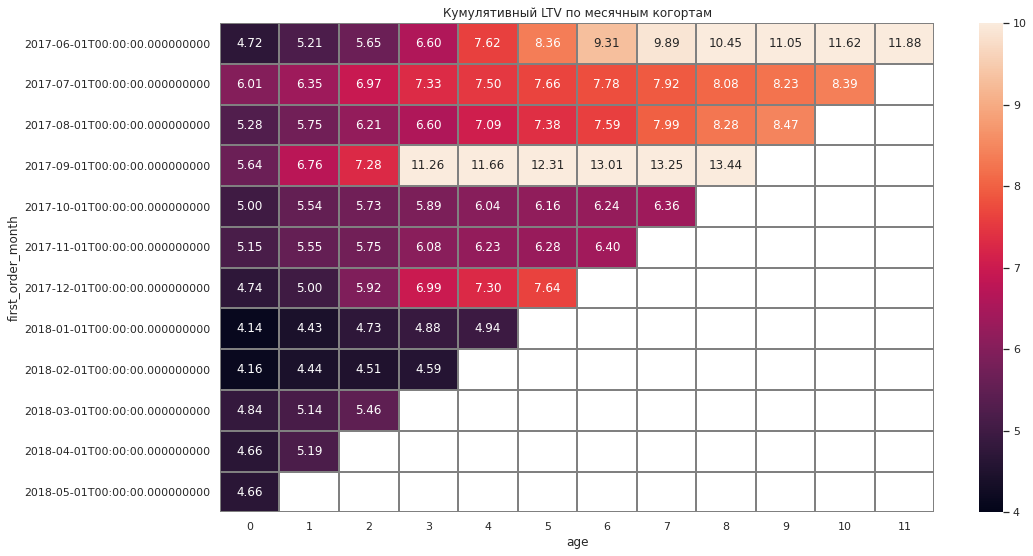

In [68]:
plt.figure(figsize=(16, 9))
plt.title('Кумулятивный LTV по месячным когортам')
sns.heatmap(ltv_pivot.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1, linecolor='gray', vmin=4, vmax=10);

Один клиент в первой когорте приносит в среднем **11,88 у.е.** Основную часть прибыли клиент приносит в первый месяц с некоторыми всплесками в последующие месяцы.

<a id="sum_up_3"></a>
**Вывод**

- В первый месяц клиенты покупают на порядок больше билетов, чем в последующие.
- При этом средний чек в первый месяц всегда ниже, чем в остальные.
- Прибыль от клиента в первый месяц значительно выше прибыли в дальнейшем.
- Один клиент в первой когорте приносит **11,88 у.е.** за год.

<a id="marketing_metrics"></a>
## Маркетинговые метрики

В данном разделе изучим расходы в течение года. Имея данные о прибыли с клиента, мы можем узнать, окупаются ли наши инвестиции.

In [69]:
costs['year'] = costs['dt'].dt.year
costs['month'] = costs['dt'].astype('datetime64[M]')

In [70]:
costs['costs'].sum()

329131.62

In [71]:
ax = (costs
     .groupby('source_id')['costs'].sum()
     .plot.bar(rot=360, grid=True, figsize=(12,6), color='tab:blue'))
ax.set_title('Расходы на маркетинг по источникам');

In [72]:
monthly_costs = costs.groupby(['year', 'month'])['costs'].sum().reset_index()

In [73]:
monthly_costs_by_source = costs.groupby(['month', 'source_id']).agg({'costs': 'sum'}).reset_index()

In [74]:
plt.figure(figsize=(24,9))
ax = sns.lineplot(data=monthly_costs_by_source,
                  x = 'month',
                  y = 'costs',
                  hue = 'source_id',
                  palette = sns.color_palette("tab10", 7),
                  dashes=False)
ax.set_title('Месячные маркетинговые расходы по источникам')
ax.set_ylabel('Расходы')
ax.set_xlabel('Дата');

Всего на привлечение потрачено более 300 тыс. у.е. Около половины всех расходов - один источник под номером 3. К концу рассматриваемого периода все маркетинговые расходы снизились, при этом мы помним, что в мае 2018 года в половине месячных когорт увеличилось количество заказов.

Узнаем, окупались ли расходы на привлечение.

In [75]:
report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')
report_new['cac'] = report_new['costs'] / report_new['uid']
report_new.head() 

first_order_month   uid order_month  revenue  age       ltv  year  \
0        2017-06-01  2023  2017-06-01  9557.49    0  4.724414  2017   
1        2017-06-01  2023  2017-07-01   981.82    1  0.485329  2017   
2        2017-06-01  2023  2017-08-01   885.34    2  0.437637  2017   
3        2017-06-01  2023  2017-09-01  1931.30    3  0.954671  2017   
4        2017-06-01  2023  2017-10-01  2068.58    4  1.022531  2017   

       month    costs       cac  
0 2017-06-01  18015.0  8.905091  
1 2017-06-01  18015.0  8.905091  
2 2017-06-01  18015.0  8.905091  
3 2017-06-01  18015.0  8.905091  
4 2017-06-01  18015.0  8.905091

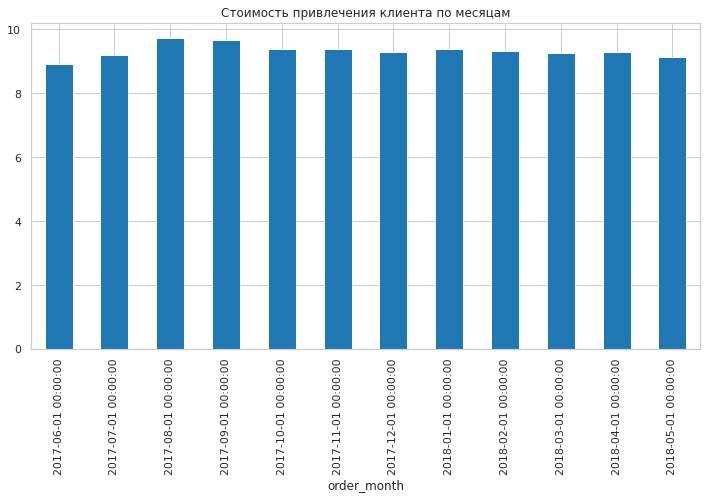

In [76]:
ax = (report_new
     .groupby('order_month')['cac'].mean()
     .plot.bar(rot=90, grid=True, figsize=(12,6), color='tab:blue')
)
ax.set_title('Стоимость привлечения клиента по месяцам');

Стоимость привлечения новых клиентов в зимний период ниже.

In [77]:
report_new['romi'] = report_new['ltv'] / report_new['cac']
romi_pivot = report_new.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean')

In [78]:
plt.figure(figsize=(16, 9))
plt.title('Окупаемость маркетинговых расходов по месячным когортам')
sns.heatmap(romi_pivot.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1, linecolor='gray');

Как видим, расходы окупаются неравномерно. Где-то когорта начинает приносить пибыль уже с 3 месяца, где-то не хватает и 9 месяцев.

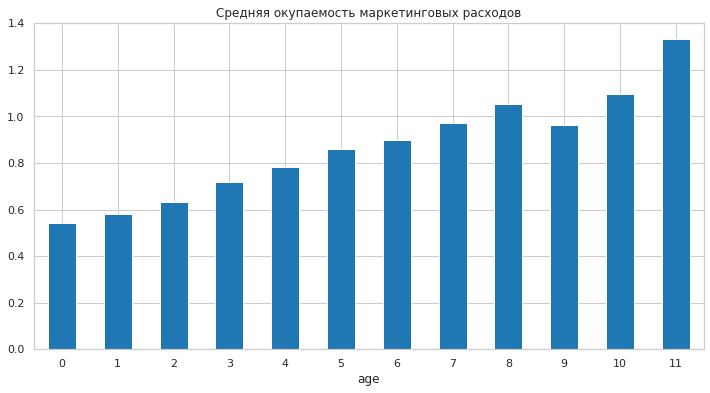

In [79]:
ax = (romi_pivot
     .cumsum(axis=1).mean(axis=0)
     .plot.bar(rot=360, grid=True, figsize=(12,6), color='tab:blue'))
ax.set_title('Средняя окупаемость маркетинговых расходов');

Если оценивать в среднем, то расходы окупаются на 8-10 месяц. Далее посмотрим на стоимость привлечения клиентов и на окупаемость маркетинговых расходов по источникам.

In [80]:
uniq_user_per_source = (visits
                        .sort_values(by='start_ts')
                        .groupby('uid')
                        .agg({'source_id': 'first'})
                        .reset_index())
orders_with_src = orders.merge(uniq_user_per_source, on='uid')
cohort_sizes_by_src = (orders_with_src
                       .groupby(['first_order_month', 'source_id'])
                       .agg({'uid': 'nunique'})
                       .reset_index())
cohort_revenue_by_src = (orders_with_src
                         .groupby(['first_order_month','order_month', 'source_id'])
                         .agg({'revenue': 'sum'})
                         .reset_index())
report_by_src = cohort_sizes_by_src.merge(cohort_revenue_by_src, on=['first_order_month', 'source_id'])

In [81]:
report_by_src['age'] = (report_by_src['order_month'] - report_by_src['first_order_month']) / np.timedelta64(1, 'M')
report_by_src['age'] = report_by_src['age'].round().astype('int')
report_by_src['ltv'] = report_by_src['revenue'] / report_by_src['uid']

In [82]:
costs_by_src = costs.groupby(['month', 'source_id']).agg({'costs': 'sum'}).reset_index()

In [83]:
report_by_src = report_by_src.merge(costs_by_src,
                                    left_on=['first_order_month', 'source_id'],
                                    right_on=['month', 'source_id'])

In [84]:
report_by_src['cac'] = report_by_src['costs'] / report_by_src['uid']
report_by_src['romi'] = report_by_src['ltv'] / report_by_src['cac']

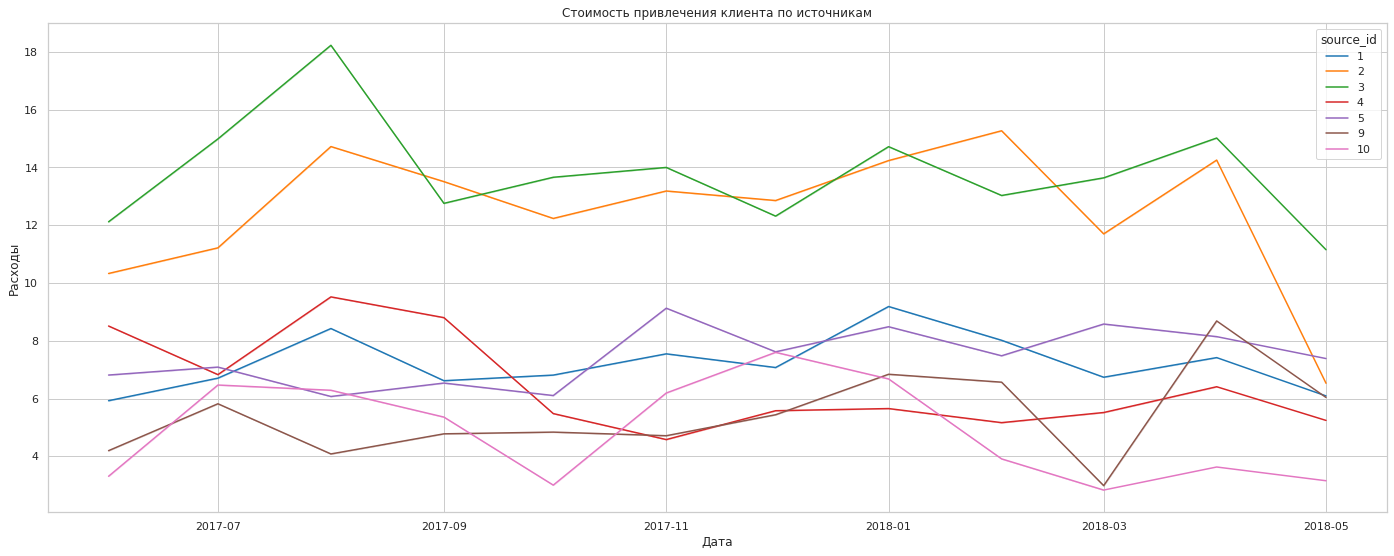

In [85]:
plt.figure(figsize=(24,9))
ax = sns.lineplot(data=report_by_src,
                  x = 'month',
                  y = 'cac',
                  hue = 'source_id',
                  dashes=False,
                  palette = sns.color_palette("tab10", 7))
ax.set_title('Стоимость привлечения клиента по источникам')
ax.set_ylabel('Расходы')
ax.set_xlabel('Дата');

Источники 2 и 3 привлекают покупателей значительно дороже, чем остальные. При этом на источник 3 израсходовано около половины всего бюджета на маркетинг.

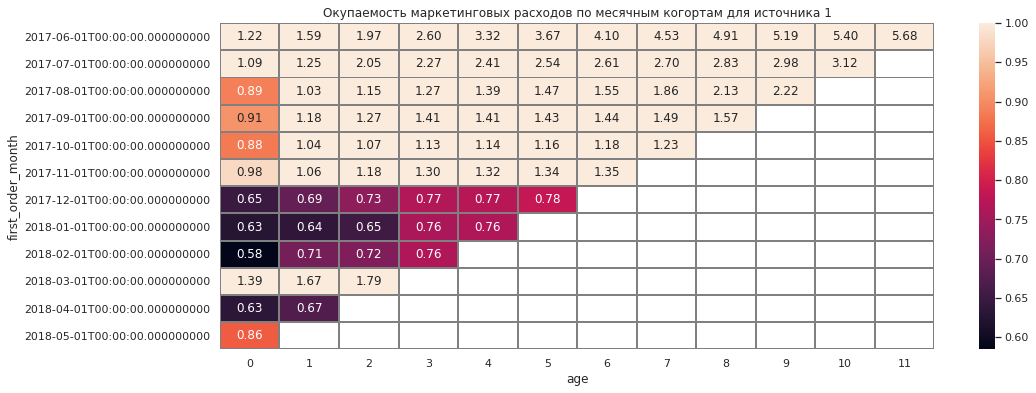

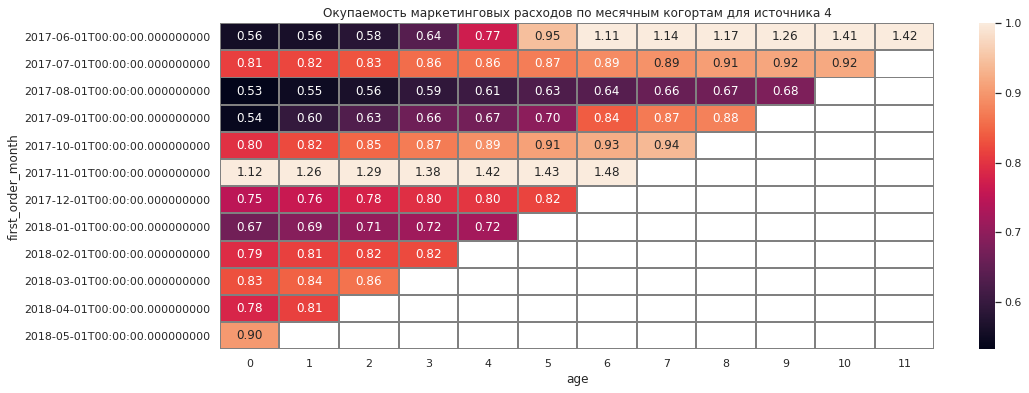

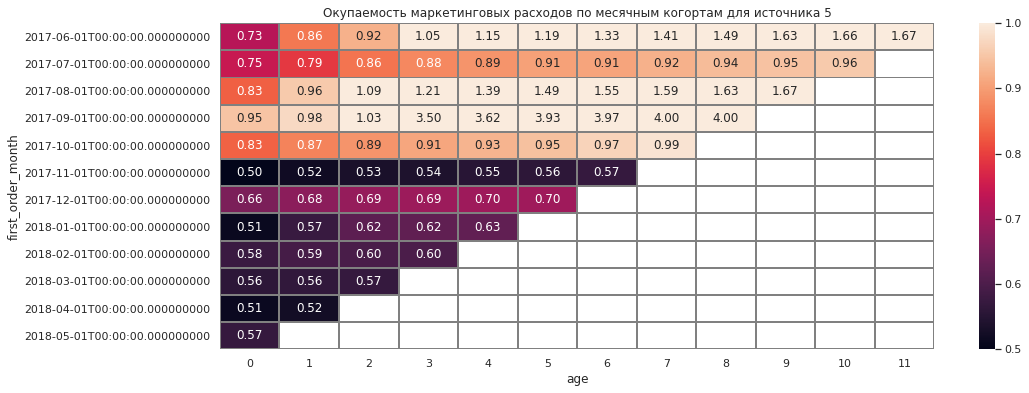

In [86]:
for group, group_data in report_by_src.groupby('source_id'):
    plt.figure(figsize=(16,6))
    plt.title('Окупаемость маркетинговых расходов по месячным когортам для источника {}'.format(group))
    gd_pivot = group_data.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean')
    sns.heatmap(gd_pivot.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1, linecolor='gray', vmax=1)

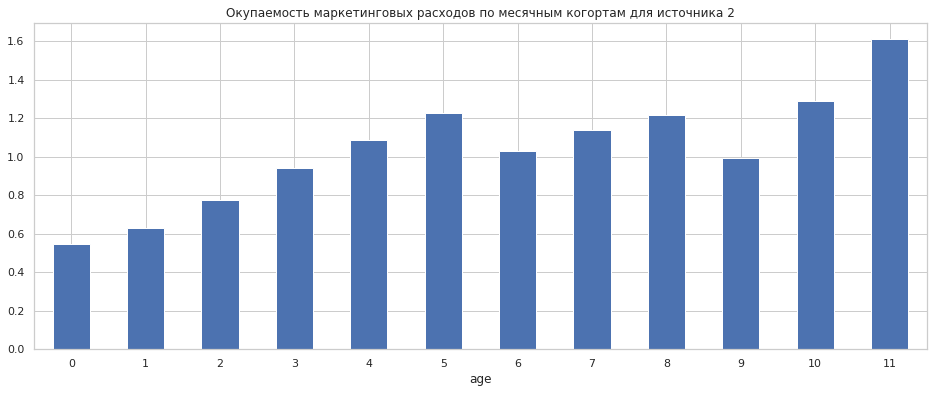

In [87]:
for group, group_data in report_by_src.groupby('source_id'):
    plt.figure(figsize=(16,6))
    plt.title('Окупаемость маркетинговых расходов по месячным когортам для источника {}'.format(group))
    gd_pivot = group_data.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean')
    gd_pivot.cumsum(axis=1).mean(axis=0).plot.bar(rot=360)

<a id="sum_up_4"></a>
**Вывод**

- За год на привлечение новых клиентов израсходовано **329 тыс. у.е.**
- Около половины расходов на привлечение затрачено на один источник (**id 3**). При этом расходы по этому источнику не окупаются за год даже на половиную.
- Расходы окупаются до 10 месяцев, при этом достаточно неравномерно в зависимости от месячной когорты.
- Источники с хорошей окупаемостью: 1, 2, 4, 5, 9.
- Источник 2 плохо окупается в когортах августа 2017 и с января по апрель 2018.
- Источники 1, 5 и 9 хуже окупаются в когортах 2018 года
- Источник 4, как и источник 2, плохо окупается в месячной когорте августа 2017

<a id="sum_up"></a>
## Общий вывод

Изучены данные Яндекс.Афиши за период с июня 2017 по конец мая 2018. На основе проведенного анализа можно сделать следующие рекомендации.

С точки зрения **пользовательской активности**:
- Наиболее частая продолжительность сессии составляет 60 секунд. Вероятно существует какая-то техническая особенность ресурса, автоматически завершающая сессию по истечении этого времени. Это может быть причиной снижения количества покупателей.
- Длительность сессии на мобильных устройствах ниже на **3,5 минуты** по сравнению с компьютерами (**8 мин** на мобильных устройствах и около **12 мин** на компьютерах). Это может быть связано как с удобством пользовательского интерфейса на различных устройствах, так и непосредственно со спецификой использования этих устройств (за компьютером пользователи обычно находятся в более спокойной обстановке, могут потратить больше времени на поиск билетов).
- Метрика sticky factor показала достаточно низкий уровень активности клиентов: **16 %** недельный показатель и **4 %** месячный. Если для компании важно повышать данный показатель, то стоит задуматься о проработке модели акций и поощрений постоянных покупателей.

С точки зрения **продаж**:
- В первый месяц количество продаж в среднем **в 10 раз больше**, чем в последующие месяцы. При этом суммарное количество продаж за все месяцы, начиная со второго, не превышает продажи в первом месяце. Здесь опять же актуально подумать о системе поощрений для частых покупателей.
- Тем не менее, средний чек в последующие месяцы наоборот растет, он всегда выше среднего чека в первый месяц. Скорее всего, новые пользователи получают скидку от ресурса на первый заказ, после чего покупают не так охотно.
- Встречаются всплески по среднему чеку и прибыли в течение года. При этом часто такие всплески привязаны к месячным когортам.

С точки зрения **расходов на привлечение новых клиентов**:
- Стоимость привлечения одного клиента окупается неравномерно и достаточно долго: **от 8 до 10 месяцев**.
- В зимний период стоимость привлечения новых клиентов падает. Компания успешно воспользовалась этим, увеличив расходы на маркетинг в зимние месяцы.

**Маркетинг в разрезе источников привлечения:**
- Источник 3 самый неэффективный из всех. На него израсходовано около половины всего бюджета, при этом стоимость привлечения одного клиента через этот источник до двух раз выше, а окупаемость не достигает **0,5** за год.
- Источник 10 тоже не окупается, но на него расходуется меньше всего средств.
- Источники 1, 2, 4, 5, 9 прибыльные.
- Самый эффективный источник - №1. При средней цене привлечения клиента расходы по данному источнику окупаются уже на второй месяц.
- Источники 1, 5, 9 хуже окупаются в месячных когортах 2018 года. Стоит обратить внимание, поскольку в 2017 году расходы по этим источникам окупались в течение 2-4 месяцев.

Основной проблемой сервиса можно назвать низкий уровень удержания клиентов, из-за чего компания вынуждена повышать расходы на привлечение новых клиентов и тратить до 10 месяцев на выход в прибыль. Также неудачная ситуация с привлечением клиентов через источник 3, на который израсходована половина бюджета и при этом окупилась только половина из этих расходов.